In [2]:
import os
from glob import glob
import cv2
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
with open("datos_Xrays256_BW", "rb") as f:
    Xrays256_BW = pickle.load(f)
    pathology_list = pickle.load(f)
    binary_labels = pickle.load(f)
    multiclass_labels = pickle.load(f)
    cancer_labels = pickle.load(f)
    index_cancer = pickle.load(f)
    index_no_cancer = pickle.load(f)

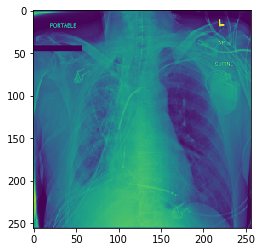

In [4]:
plt.imshow(Xrays256_BW[0]); #cvimage is a numpy array

### Paso por red preentrenada

In [5]:
#from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
base_vgg_model = VGG16(input_shape=(256,256,3),
                       include_top=False,
                       weights = 'imagenet')

In [7]:
base_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [8]:
aux = np.zeros((1,256,256,3))
a = Xrays256_BW[0]
for i in range(3):
    aux[0,:,:,i] = a

In [9]:
a = base_vgg_model.predict(aux)

In [10]:
a.shape

(1, 8, 8, 512)

In [11]:
512*8*8

32768

In [12]:
base_vgg_model_global_average = Sequential()
base_vgg_model_global_average.add(base_vgg_model)
base_vgg_model_global_average.add(GlobalAveragePooling2D())
#base_vgg_model_global_average.add(Flatten())

base_vgg_model_global_average.compile(optimizer='adam', loss = 'mse')

In [13]:
base_vgg_model_global_average.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [14]:
a = base_vgg_model_global_average.predict(aux)[0]

In [15]:
a.shape

(512,)

In [16]:
len(Xrays256_BW)


5606

### Creamos ahora el fichero con las imágenes pasadas por la red preentrenada

In [17]:
%%time 
features_preentrenada = np.zeros((len(Xrays256_BW), len(a)))
aux = np.zeros((1,256,256,3))

for n in range(len(Xrays256_BW)):
    for i in range(3):
        aux[0,:,:,i] = Xrays256_BW[n]
    features_preentrenada[n] = base_vgg_model_global_average.predict(aux)[0]
    if (n+1) % 10 == 0:
        print("Procesando imagen {}/{}".format(n+1, len(Xrays256_BW)))

Procesando imagen 10/5606
Procesando imagen 20/5606
Procesando imagen 30/5606
Procesando imagen 40/5606
Procesando imagen 50/5606
Procesando imagen 60/5606
Procesando imagen 70/5606
Procesando imagen 80/5606
Procesando imagen 90/5606
Procesando imagen 100/5606
Procesando imagen 110/5606
Procesando imagen 120/5606
Procesando imagen 130/5606
Procesando imagen 140/5606
Procesando imagen 150/5606
Procesando imagen 160/5606
Procesando imagen 170/5606
Procesando imagen 180/5606
Procesando imagen 190/5606
Procesando imagen 200/5606
Procesando imagen 210/5606
Procesando imagen 220/5606
Procesando imagen 230/5606
Procesando imagen 240/5606
Procesando imagen 250/5606
Procesando imagen 260/5606
Procesando imagen 270/5606
Procesando imagen 280/5606
Procesando imagen 290/5606
Procesando imagen 300/5606
Procesando imagen 310/5606
Procesando imagen 320/5606
Procesando imagen 330/5606
Procesando imagen 340/5606
Procesando imagen 350/5606
Procesando imagen 360/5606
Procesando imagen 370/5606
Procesando

In [21]:
with open("features_Xrays256_BW", "wb") as f:
    pickle.dump(Xrays256_BW, f)
    pickle.dump(pathology_list, f)
    pickle.dump(binary_labels, f)
    pickle.dump(multiclass_labels, f)
    pickle.dump(cancer_labels, f)
    pickle.dump(index_cancer, f)
    pickle.dump(index_no_cancer, f)


In [22]:
with open("features_Xrays256_BW_2", "wb") as f:
    pickle.dump(features_preentrenada, f,protocol=4)

#https://stackoverflow.com/questions/29704139/pickle-in-python3-doesnt-work-for-large-data-saving

In [20]:
from contextlib import redirect_stdout
import datetime as dt

with open(dt.datetime.now().strftime("%Y%m%d_%H%M_")+'arquitectura_preentrenada'+'.txt', 'w') as f:
    with redirect_stdout(f):
        base_vgg_model_global_average.summary()
        
# https://stackoverflow.com/questions/45199047/how-to-save-model-summary-to-file-in-keras